---
## Import Library

In [2]:
#Modifikasi
import warnings
import zipfile
import numpy as np
import pandas as pd
from pathlib import Path
pd.set_option('display.max_columns', 100)

#Visualisasi
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly_express as px
import plotly.subplots as sp
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib import rcParams

#Perhitungan
import itertools
from statsmodels.formula.api import ols
import statsmodels.api as sm
from geopy.geocoders import Nominatim
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose


#Imputasi
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression


# Modeling
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV, GroupKFold,KFold, TimeSeriesSplit   
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc,roc_auc_score, mean_squared_error
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

#Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# Feature Importance
from sklearn.ensemble import ExtraTreesClassifier

---
## Load Data

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

---
## Data Understanding

In [4]:
train.head()

,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,vent_hist,renal_issue,pulm_severe,prim_disease_hct,hla_high_res_6,cmv_status,hla_high_res_10,hla_match_dqb1_high,tce_imm_match,hla_nmdp_6,hla_match_c_low,rituximab,hla_match_drb1_low,hla_match_dqb1_low,prod_type,cyto_score_detail,conditioning_intensity,ethnicity,year_hct,obesity,mrd_hct,in_vivo_tcd,tce_match,hla_match_a_high,hepatic_severe,donor_age,prior_tumor,hla_match_b_low,peptic_ulcer,age_at_hct,hla_match_a_low,gvhd_proph,rheum_issue,sex_match,hla_match_b_high,race_group,comorbidity_score,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time
0,0,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,Bone marrow,No,No,No,IEA,6.0,+/+,NaN,2.0,NaN,6.0,2.0,No,2.0,2.0,BM,NaN,NaN,Not Hispanic or Latino,2016,No,NaN,Yes,NaN,2.0,No,NaN,No,2.0,No,9.942,2.0,FKalone,No,M-F,2.0,More than one race,0.0,90.0,No,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,42.356
1,1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,Peripheral blood,No,No,No,AML,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,PB,Intermediate,MAC,Not Hispanic or Latino,2008,No,Positive,No,Permissive,2.0,No,72.29,No,2.0,No,43.705,2.0,Other GVHD Prophylaxis,No,F-F,2.0,Asian,3.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,1.0,4.672
2,2,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,HIS,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,NaN,NaN,Not Hispanic or Latino,2019,No,NaN,Yes,NaN,2.0,No,NaN,No,2.0,No,33.997,2.0,Cyclophosphamide alone,No,F-M,2.0,More than one race,0.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,19.793
3,3,High,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,ALL,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,Intermediate,MAC,Not Hispanic or Latino,2009,No,Positive,No,Permissive,2.0,No,29.23,No,2.0,No,43.245,2.0,FK+ MMF +- others,No,M-M,2.0,White,0.0,90.0,Yes,Permissive mismatched,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,102.349
4,4,High,No,NaN,No,2.0,8.0,No TBI,No,6.0,Peripheral blood,No,No,No,MPN,6.0,+/+,10.0,2.0,NaN,5.0,2.0,No,2.0,2.0,PB,NaN,MAC,Hispanic or Latino,2018,No,NaN,Yes,NaN,2.0,No,56.81,No,2.0,No,29.740,2.0,TDEPLETION +- other,No,M-F,2.0,American Indian or Alaska Native,1.0,90.0,No,Permissive mismatched,Related,MEL,8.0,No,2.0,No,10.0,0.0,16.223


In [5]:
test.head()

,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,vent_hist,renal_issue,pulm_severe,prim_disease_hct,hla_high_res_6,cmv_status,hla_high_res_10,hla_match_dqb1_high,tce_imm_match,hla_nmdp_6,hla_match_c_low,rituximab,hla_match_drb1_low,hla_match_dqb1_low,prod_type,cyto_score_detail,conditioning_intensity,ethnicity,year_hct,obesity,mrd_hct,in_vivo_tcd,tce_match,hla_match_a_high,hepatic_severe,donor_age,prior_tumor,hla_match_b_low,peptic_ulcer,age_at_hct,hla_match_a_low,gvhd_proph,rheum_issue,sex_match,hla_match_b_high,race_group,comorbidity_score,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10
0,28800,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,Bone marrow,No,No,No,IEA,6.0,+/+,NaN,2.0,NaN,6.0,2.0,No,2.0,2.0,BM,NaN,NaN,Not Hispanic or Latino,2016,No,NaN,Yes,NaN,2.0,No,NaN,No,2.0,No,9.942,2.0,FKalone,No,M-F,2.0,More than one race,0.0,90.0,No,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0
1,28801,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,Peripheral blood,No,No,No,AML,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,PB,Intermediate,MAC,Not Hispanic or Latino,2008,No,Positive,No,Permissive,2.0,No,72.29,No,2.0,No,43.705,2.0,Other GVHD Prophylaxis,No,F-F,2.0,Asian,3.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0
2,28802,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,HIS,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,NaN,NaN,Not Hispanic or Latino,2019,No,NaN,Yes,NaN,2.0,No,NaN,No,2.0,No,33.997,2.0,Cyclophosphamide alone,No,F-M,2.0,More than one race,0.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0


In [6]:
sample_submission.head()

,ID,prediction
0,28800,0.5
1,28801,0.5
2,28802,0.5


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28800 entries, 0 to 28799
Data columns (total 60 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      28800 non-null  int64  
 1   dri_score               28646 non-null  object 
 2   psych_disturb           26738 non-null  object 
 3   cyto_score              20732 non-null  object 
 4   diabetes                26681 non-null  object 
 5   hla_match_c_high        24180 non-null  float64
 6   hla_high_res_8          22971 non-null  float64
 7   tbi_status              28800 non-null  object 
 8   arrhythmia              26598 non-null  object 
 9   hla_low_res_6           25530 non-null  float64
 10  graft_type              28800 non-null  object 
 11  vent_hist               28541 non-null  object 
 12  renal_issue             26885 non-null  object 
 13  pulm_severe             26665 non-null  object 
 14  prim_disease_hct        28800 non-null

In [8]:
train.describe()

,ID,hla_match_c_high,hla_high_res_8,hla_low_res_6,hla_high_res_6,hla_high_res_10,hla_match_dqb1_high,hla_nmdp_6,hla_match_c_low,hla_match_drb1_low,hla_match_dqb1_low,year_hct,hla_match_a_high,donor_age,hla_match_b_low,age_at_hct,hla_match_a_low,hla_match_b_high,comorbidity_score,karnofsky_score,hla_low_res_8,hla_match_drb1_high,hla_low_res_10,efs,efs_time
count,28800.000000,24180.000000,22971.000000,25530.000000,23516.000000,21637.000000,23601.000000,24603.000000,26000.000000,26157.000000,24606.000000,28800.000000,24499.000000,26992.000000,26235.000000,28800.000000,26410.000000,24712.00000,28323.000000,27930.00000,25147.000000,25448.000000,23736.000000,28800.000000,28800.000000
mean,14399.500000,1.764516,6.876801,5.143322,5.109202,8.617230,1.736876,5.160346,1.757808,1.715296,1.773795,2015.179444,1.703743,42.511591,1.719916,38.663162,1.709087,1.69962,1.702327,83.83208,6.903448,1.707128,8.664687,0.539306,23.237678
std,8313.988213,0.431941,1.564313,1.207757,1.214162,1.905125,0.447687,1.203240,0.435453,0.451282,0.427130,3.153914,0.462213,15.251434,0.454449,21.147581,0.458259,0.46518,1.994443,11.02884,1.565017,0.461179,1.882746,0.498461,24.799748
min,0.000000,0.000000,2.000000,2.000000,0.000000,3.000000,0.000000,2.000000,0.000000,1.000000,0.000000,2008.000000,0.000000,18.010000,0.000000,0.044000,0.000000,0.00000,0.000000,40.00000,2.000000,0.000000,4.000000,0.000000,0.333000
25%,7199.750000,2.000000,6.000000,4.000000,4.000000,7.000000,1.000000,4.000000,2.000000,1.000000,2.000000,2013.000000,1.000000,28.447000,1.000000,19.539000,1.000000,1.00000,0.000000,70.00000,6.000000,1.000000,7.000000,0.000000,5.619750
50%,14399.500000,2.000000,8.000000,6.000000,6.000000,10.000000,2.000000,6.000000,2.000000,2.000000,2.000000,2016.000000,2.000000,40.063000,2.000000,41.006000,2.000000,2.00000,1.000000,90.00000,8.000000,2.000000,10.000000,1.000000,9.796500
75%,21599.250000,2.000000,8.000000,6.000000,6.000000,10.000000,2.000000,6.000000,2.000000,2.000000,2.000000,2018.000000,2.000000,56.131500,2.000000,55.965250,2.000000,2.00000,2.000000,90.00000,8.000000,2.000000,10.000000,1.000000,35.100000
max,28799.000000,2.000000,8.000000,6.000000,6.000000,10.000000,2.000000,6.000000,2.000000,2.000000,2.000000,2020.000000,2.000000,84.800000,2.000000,73.726000,2.000000,2.00000,10.000000,100.00000,8.000000,2.000000,10.000000,1.000000,156.819000


In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 58 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      3 non-null      int64  
 1   dri_score               3 non-null      object 
 2   psych_disturb           3 non-null      object 
 3   cyto_score              1 non-null      object 
 4   diabetes                3 non-null      object 
 5   hla_match_c_high        2 non-null      float64
 6   hla_high_res_8          2 non-null      float64
 7   tbi_status              3 non-null      object 
 8   arrhythmia              3 non-null      object 
 9   hla_low_res_6           3 non-null      float64
 10  graft_type              3 non-null      object 
 11  vent_hist               3 non-null      object 
 12  renal_issue             3 non-null      object 
 13  pulm_severe             3 non-null      object 
 14  prim_disease_hct        3 non-null      object

In [10]:
test.describe()

,ID,hla_match_c_high,hla_high_res_8,hla_low_res_6,hla_high_res_6,hla_high_res_10,hla_match_dqb1_high,hla_nmdp_6,hla_match_c_low,hla_match_drb1_low,hla_match_dqb1_low,year_hct,hla_match_a_high,donor_age,hla_match_b_low,age_at_hct,hla_match_a_low,hla_match_b_high,comorbidity_score,karnofsky_score,hla_low_res_8,hla_match_drb1_high,hla_low_res_10
count,3.0,2.0,2.0,3.0,3.0,2.0,3.0,3.0,3.0,3.0,3.0,3.000000,3.0,1.00,3.0,3.000000,3.0,3.0,3.000000,3.0,3.0,3.0,3.0
mean,28801.0,2.0,8.0,6.0,6.0,10.0,2.0,6.0,2.0,2.0,2.0,2014.333333,2.0,72.29,2.0,29.214667,2.0,2.0,1.000000,90.0,8.0,2.0,10.0
std,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.686241,0.0,NaN,0.0,17.382119,0.0,0.0,1.732051,0.0,0.0,0.0,0.0
min,28800.0,2.0,8.0,6.0,6.0,10.0,2.0,6.0,2.0,2.0,2.0,2008.000000,2.0,72.29,2.0,9.942000,2.0,2.0,0.000000,90.0,8.0,2.0,10.0
25%,28800.5,2.0,8.0,6.0,6.0,10.0,2.0,6.0,2.0,2.0,2.0,2012.000000,2.0,72.29,2.0,21.969500,2.0,2.0,0.000000,90.0,8.0,2.0,10.0
50%,28801.0,2.0,8.0,6.0,6.0,10.0,2.0,6.0,2.0,2.0,2.0,2016.000000,2.0,72.29,2.0,33.997000,2.0,2.0,0.000000,90.0,8.0,2.0,10.0
75%,28801.5,2.0,8.0,6.0,6.0,10.0,2.0,6.0,2.0,2.0,2.0,2017.500000,2.0,72.29,2.0,38.851000,2.0,2.0,1.500000,90.0,8.0,2.0,10.0
max,28802.0,2.0,8.0,6.0,6.0,10.0,2.0,6.0,2.0,2.0,2.0,2019.000000,2.0,72.29,2.0,43.705000,2.0,2.0,3.000000,90.0,8.0,2.0,10.0


In [11]:
train.shape, test.shape, sample_submission.shape

((28800, 60), (3, 58), (3, 2))

In [12]:
for col in train.columns:
    print(f"Unique Value kolom {col} : {train[col].nunique()}")

Unique Value kolom ID : 28800
Unique Value kolom dri_score : 11
Unique Value kolom psych_disturb : 3
Unique Value kolom cyto_score : 7
Unique Value kolom diabetes : 3
Unique Value kolom hla_match_c_high : 3
Unique Value kolom hla_high_res_8 : 7
Unique Value kolom tbi_status : 8
Unique Value kolom arrhythmia : 3
Unique Value kolom hla_low_res_6 : 5
Unique Value kolom graft_type : 2
Unique Value kolom vent_hist : 2
Unique Value kolom renal_issue : 3
Unique Value kolom pulm_severe : 3
Unique Value kolom prim_disease_hct : 18
Unique Value kolom hla_high_res_6 : 6
Unique Value kolom cmv_status : 4
Unique Value kolom hla_high_res_10 : 8
Unique Value kolom hla_match_dqb1_high : 3
Unique Value kolom tce_imm_match : 8
Unique Value kolom hla_nmdp_6 : 5
Unique Value kolom hla_match_c_low : 3
Unique Value kolom rituximab : 2
Unique Value kolom hla_match_drb1_low : 2
Unique Value kolom hla_match_dqb1_low : 3
Unique Value kolom prod_type : 2
Unique Value kolom cyto_score_detail : 5
Unique Value kolo

In [13]:
catCols = train.select_dtypes(include='object')
numCols = train.select_dtypes(exclude='object')

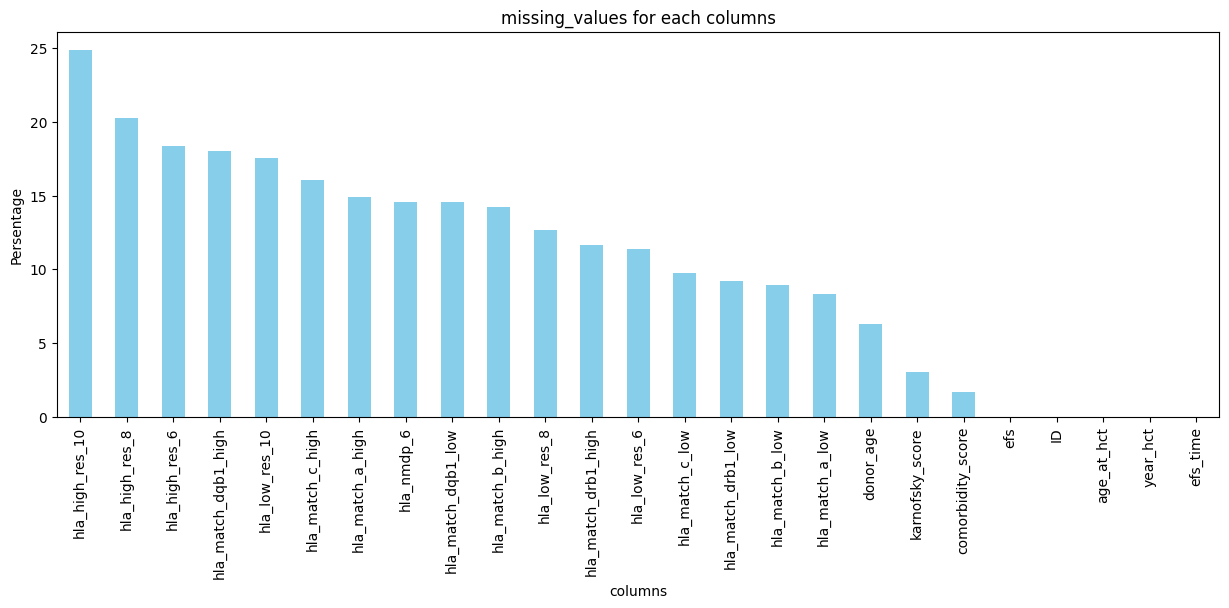

In [14]:
missing_values_numCols = ((numCols.isnull().sum() / len(numCols)) * 100).sort_values(ascending=False)
missing_values_numCols.plot(kind='bar',color='skyblue',figsize=(15,5))
plt.title("missing_values for each columns")
plt.xlabel("columns")
plt.ylabel("Persentage")
plt.show()

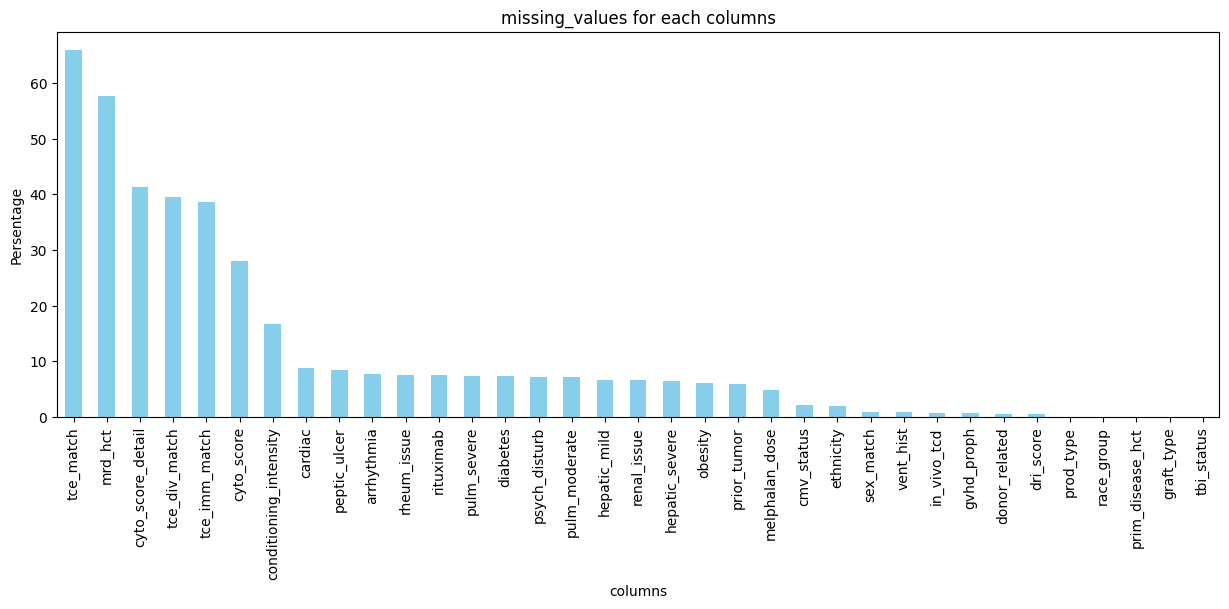

In [15]:
missing_values_catCols = ((catCols.isnull().sum() / len(catCols)) * 100).sort_values(ascending=False)
missing_values_catCols.plot(kind='bar',color='skyblue',figsize=(15,5))
plt.title("missing_values for each columns")
plt.xlabel("columns")
plt.ylabel("Persentage")
plt.show()

##### Karna lebih dari 60% better drop aja ya, dari pada isinya kacau

In [16]:
# train.drop(['tce_match','mrd_hct','ID'],axis=1,inplace=True)

---
## Merge target into one

In [17]:
from lifelines import KaplanMeierFitter
def transform_survival_probability(df, time_col='efs_time', event_col='efs'):
    kmf = KaplanMeierFitter()
    kmf.fit(df[time_col], df[event_col])
    y = kmf.survival_function_at_times(df[time_col]).values
    return y
train["y"] = transform_survival_probability(train, time_col='efs_time', event_col='efs')

In [18]:
RMV = ["ID","efs","efs_time","y"]
FEATURES = [c for c in train.columns if not c in RMV]
print(f"There are {len(FEATURES)} FEATURES: {FEATURES}")

There are 57 FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10']


In [19]:
CATS = []
for c in FEATURES:
    if train[c].dtype=="object":
        CATS.append(c)
        train[c] = train[c].fillna("NAN")
        test[c] = test[c].fillna("NAN")
print(f"In these features, there are {len(CATS)} CATEGORICAL FEATURES: {CATS}")

for c in FEATURES:
    if train[c].dtype == 'object':
        print(f"Converting {c} to category")
        train[c] = train[c].astype('category')
        test[c] = test[c].astype('category')

In these features, there are 35 CATEGORICAL FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'tbi_status', 'arrhythmia', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'cmv_status', 'tce_imm_match', 'rituximab', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hepatic_severe', 'prior_tumor', 'peptic_ulcer', 'gvhd_proph', 'rheum_issue', 'sex_match', 'race_group', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'cardiac', 'pulm_moderate']
Converting dri_score to category
Converting psych_disturb to category
Converting cyto_score to category
Converting diabetes to category
Converting tbi_status to category
Converting arrhythmia to category
Converting graft_type to category
Converting vent_hist to category
Converting renal_issue to category
Converting pulm_severe to category
Converting prim_disease_hct to category
Converting cmv_status to category
C

In [20]:
combined = pd.concat([train, test], axis=0, ignore_index=True)

# Label encode categorical features
print("We LABEL ENCODE the CATEGORICAL FEATURES: ", end="")
for c in FEATURES:
    if c in CATS:
        print(f"{c}, ", end="")
        
        # Faktorize and convert to category directly
        combined[c], _ = combined[c].factorize()
        combined[c] = combined[c].astype("category")
        
    # Reduce precision of numerical columns to save memory
    else:
        if combined[c].dtype == "float64":
            combined[c] = combined[c].astype("float32")
        elif combined[c].dtype == "int64":
            combined[c] = combined[c].astype("int32")

# Separate back into train and test datasets
train = combined.iloc[:len(train)].copy()
test = combined.iloc[len(train):].reset_index(drop=True).copy()

# drop_columns = ['ID', 'mrd_hct', 'tce_match']

# # Menghapus kolom pada data train dan test
# train = train.drop(columns=drop_columns)
# test = test.drop(columns=drop_columns)

We LABEL ENCODE the CATEGORICAL FEATURES: dri_score, psych_disturb, cyto_score, diabetes, tbi_status, arrhythmia, graft_type, vent_hist, renal_issue, pulm_severe, prim_disease_hct, cmv_status, tce_imm_match, rituximab, prod_type, cyto_score_detail, conditioning_intensity, ethnicity, obesity, mrd_hct, in_vivo_tcd, tce_match, hepatic_severe, prior_tumor, peptic_ulcer, gvhd_proph, rheum_issue, sex_match, race_group, hepatic_mild, tce_div_match, donor_related, melphalan_dose, cardiac, pulm_moderate, 

In [27]:
def logit(p):
    return np.log(p) - np.log(1 - p)

# Identifikasi fitur numerik
numerical_features = train.select_dtypes(include=[np.number]).columns

# Terapkan logit hanya pada fitur yang berada di antara 0 dan 1
for var in numerical_features:
    # Pastikan nilai dalam rentang yang valid (0 < p < 1)
    if train[var].min() > 0 and train[var].max() < 1:
        train[f'logit_{var}'] = train[var].apply(logit)
    else:
        print(f"Fitur {var} tidak dalam rentang 0 hingga 1, tidak diterapkan logit.")

Fitur ID tidak dalam rentang 0 hingga 1, tidak diterapkan logit.
Fitur hla_match_c_high tidak dalam rentang 0 hingga 1, tidak diterapkan logit.
Fitur hla_high_res_8 tidak dalam rentang 0 hingga 1, tidak diterapkan logit.
Fitur hla_low_res_6 tidak dalam rentang 0 hingga 1, tidak diterapkan logit.
Fitur hla_high_res_6 tidak dalam rentang 0 hingga 1, tidak diterapkan logit.
Fitur hla_high_res_10 tidak dalam rentang 0 hingga 1, tidak diterapkan logit.
Fitur hla_match_dqb1_high tidak dalam rentang 0 hingga 1, tidak diterapkan logit.
Fitur hla_nmdp_6 tidak dalam rentang 0 hingga 1, tidak diterapkan logit.
Fitur hla_match_c_low tidak dalam rentang 0 hingga 1, tidak diterapkan logit.
Fitur hla_match_drb1_low tidak dalam rentang 0 hingga 1, tidak diterapkan logit.
Fitur hla_match_dqb1_low tidak dalam rentang 0 hingga 1, tidak diterapkan logit.
Fitur year_hct tidak dalam rentang 0 hingga 1, tidak diterapkan logit.
Fitur hla_match_a_high tidak dalam rentang 0 hingga 1, tidak diterapkan logit.
Fit

---
## Model Building

In [21]:
from sklearn.model_selection import KFold
from xgboost import XGBRegressor, XGBClassifier
import xgboost as xgb
FOLDS = 10
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)
    
oof_xgb = np.zeros(len(train))
pred_xgb = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)
    
    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"y"]
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"y"]
    x_test = test[FEATURES].copy()

    model_xgb = XGBRegressor(
        device="cuda",
        max_depth=3,  
        colsample_bytree=0.5,  
        subsample=0.8,  
        n_estimators=2000,  
        learning_rate=0.02,  
        enable_categorical=True,
        min_child_weight=80,
        #early_stopping_rounds=25,
    )
    model_xgb.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],  
        verbose=500 
    )

    # INFER OOF
    oof_xgb[test_index] = model_xgb.predict(x_valid)
    # INFER TEST
    pred_xgb += model_xgb.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_xgb /= FOLDS

#########################
### Fold 1
#########################
[0]	validation_0-rmse:0.17783
[500]	validation_0-rmse:0.15941
[1000]	validation_0-rmse:0.15731
[1500]	validation_0-rmse:0.15641
[1999]	validation_0-rmse:0.15599


C:\Users\booma\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:160: UserWarning:

[22:26:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.




#########################
### Fold 2
#########################
[0]	validation_0-rmse:0.17362
[500]	validation_0-rmse:0.15586
[1000]	validation_0-rmse:0.15426
[1500]	validation_0-rmse:0.15368
[1999]	validation_0-rmse:0.15333
#########################
### Fold 3
#########################
[0]	validation_0-rmse:0.17733
[500]	validation_0-rmse:0.15802
[1000]	validation_0-rmse:0.15606
[1500]	validation_0-rmse:0.15532
[1999]	validation_0-rmse:0.15494
#########################
### Fold 4
#########################
[0]	validation_0-rmse:0.17932
[500]	validation_0-rmse:0.16001
[1000]	validation_0-rmse:0.15798
[1500]	validation_0-rmse:0.15709
[1999]	validation_0-rmse:0.15662
#########################
### Fold 5
#########################
[0]	validation_0-rmse:0.17377
[500]	validation_0-rmse:0.15731
[1000]	validation_0-rmse:0.15561
[1500]	validation_0-rmse:0.15477
[1999]	validation_0-rmse:0.15433
#########################
### Fold 6
#########################
[0]	validation_0-rmse:0.17758
[500]	valid

In [22]:
from lightgbm import LGBMRegressor
import lightgbm as lgb
FOLDS = 10
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)
    
oof_lgb = np.zeros(len(train))
pred_lgb = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)
    
    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"y"]    
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"y"]
    x_test = test[FEATURES].copy()

    model_lgb = LGBMRegressor(
        device="gpu", 
        max_depth=3, 
        colsample_bytree=0.4,  
        #subsample=0.9, 
        n_estimators=2500, 
        learning_rate=0.02, 
        objective="regression", 
        verbose=-1, 
        #early_stopping_rounds=25,
    )
    model_lgb.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],
    )
    
    # INFER OOF
    oof_lgb[test_index] = model_lgb.predict(x_valid)
    # INFER TEST
    pred_lgb += model_lgb.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_lgb /= FOLDS

#########################
### Fold 1
#########################
#########################
### Fold 2
#########################
#########################
### Fold 3
#########################
#########################
### Fold 4
#########################
#########################
### Fold 5
#########################
#########################
### Fold 6
#########################
#########################
### Fold 7
#########################
#########################
### Fold 8
#########################
#########################
### Fold 9
#########################
#########################
### Fold 10
#########################


In [23]:
# Melatih model dengan seluruh data train dan membuat prediksi pada data test
final_model_xgb = XGBRegressor(
    device="cuda",
    max_depth=3,  
    colsample_bytree=0.5,  
    subsample=0.8,  
    n_estimators=2000,  
    learning_rate=0.02,  
    enable_categorical=True,
    min_child_weight=80,
)

# Melatih model pada seluruh data train
final_model_xgb.fit(train[FEATURES], train["y"])

# Membuat prediksi pada data test
test_predictions = final_model_xgb.predict(test[FEATURES])

# Menyimpan prediksi untuk data test ke dalam dataframe
test["predictions"] = test_predictions


In [24]:
test

,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,vent_hist,renal_issue,pulm_severe,prim_disease_hct,hla_high_res_6,cmv_status,hla_high_res_10,hla_match_dqb1_high,tce_imm_match,hla_nmdp_6,hla_match_c_low,rituximab,hla_match_drb1_low,hla_match_dqb1_low,prod_type,cyto_score_detail,conditioning_intensity,ethnicity,year_hct,obesity,mrd_hct,in_vivo_tcd,tce_match,hla_match_a_high,hepatic_severe,donor_age,prior_tumor,hla_match_b_low,peptic_ulcer,age_at_hct,hla_match_a_low,gvhd_proph,rheum_issue,sex_match,hla_match_b_high,race_group,comorbidity_score,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time,y,predictions
0,28800,0,0,0,0,NaN,NaN,0,0,6.0,0,0,0,0,0,6.0,0,NaN,2.0,0,6.0,2.0,0,2.0,2.0,0,0,0,0,2016,0,0,0,0,2.0,0,NaN,0,2.0,0,9.942000,2.0,0,0,0,2.0,0,0.0,90.0,0,0,0,0,8.0,0,2.0,0,10.0,NaN,NaN,NaN,0.489019
1,28801,1,0,1,0,2.0,8.0,1,0,6.0,1,0,0,0,1,6.0,0,10.0,2.0,1,6.0,2.0,0,2.0,2.0,1,1,1,0,2008,0,1,1,1,2.0,0,72.290001,0,2.0,0,43.705002,2.0,1,0,1,2.0,1,3.0,90.0,0,1,1,0,8.0,0,2.0,1,10.0,NaN,NaN,NaN,0.634346
2,28802,0,0,0,0,2.0,8.0,0,0,6.0,0,0,0,0,2,6.0,0,10.0,2.0,1,6.0,2.0,0,2.0,2.0,0,0,0,0,2019,0,0,0,0,2.0,0,NaN,0,2.0,0,33.997002,2.0,2,0,2,2.0,0,0.0,90.0,0,1,1,0,8.0,0,2.0,0,10.0,NaN,NaN,NaN,0.430862


---
## Submission

In [25]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission['prediction'] = test_predictions

In [26]:
sample_submission.to_csv('submission.csv',index=False)